In [1]:
from PIL import Image
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms
import time
import cv2
import numpy as np

In [2]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        
        self.resblock = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(channels, affine=True),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(channels, affine=True),
        )
        
    def forward(self, x):
        out = self.resblock(x)
        return out + x

class MicroResNet(nn.Module):
    def __init__(self):
        super(MicroResNet, self).__init__()
        
        self.downsampler = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=9, padding=4, stride=2),
            nn.InstanceNorm2d(4, affine=True),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=3, padding=1, stride=2),
            nn.InstanceNorm2d(8, affine=True),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=2),
            nn.InstanceNorm2d(16, affine=True),
            nn.ReLU()
        )
        
        self.residual = nn.Sequential(
            ResBlock(16),
            ResBlock(16)
        )
        
        self.segmentator = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.InstanceNorm2d(8, affine=True),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=9, padding=4),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.downsampler(x)
        out = self.residual(out)
        out = self.segmentator(out)
        return out

In [3]:
model = MicroResNet()

checkpoint = torch.load('saliency_model_v6.pt')
model.load_state_dict(checkpoint)
model.eval()

MicroResNet(
  (downsampler): Sequential(
    (0): Conv2d(3, 4, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
    (1): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU()
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): ReLU()
    (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (8): ReLU()
  )
  (residual): Sequential(
    (0): ResBlock(
      (resblock): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU()
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): InstanceNorm2d(16, eps=1e-05, momentum=0.1, af

Processed in 0.02664377450942993 seconds


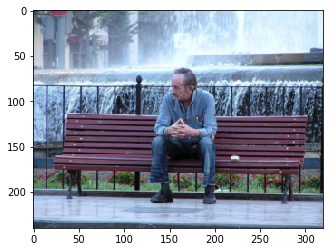

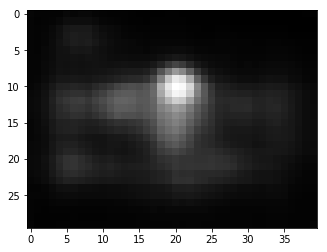

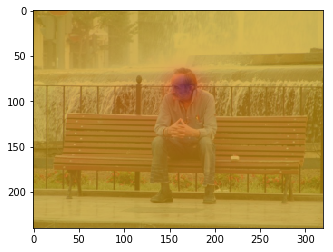

In [6]:
with torch.no_grad():
    path = '../images/COCO_train2014_000000000510.jpg'
    image = Image.open(path)
    image = transforms.ToTensor()(transforms.Resize(240)(image)).unsqueeze(0)

    total_time = 0
    for i in range(100):
        initial_time = time.time()
        heatmap = model.forward(image)[0]
        total_time += time.time() - initial_time
    print(f'Processed in {total_time/100} seconds')

    heatmap_h, heatmap_w = heatmap.size(1), heatmap.size(2)

    plt.imshow(image[0].permute(1, 2, 0))
    plt.show()

    temperature = 2
    tempered_heatmap = torch.log(torch.softmax(heatmap.view(-1), dim=0)) / temperature
    tempered_heatmap = torch.exp(tempered_heatmap) / torch.sum(torch.exp(tempered_heatmap))

    hm = tempered_heatmap.view(heatmap_h, heatmap_w)
    # hm[hm < hm.max() * 0.5] = 0
    plt.imshow(hm, cmap='Greys_r')
    plt.show()
    
    heatmap_img = cv2.resize(hm.numpy(), (heatmap_w*8, heatmap_h*8))
    heatmap_img = cv2.applyColorMap(((1-(heatmap_img / heatmap_img.max())) * 255).astype(np.uint8), cv2.COLORMAP_PARULA)
    weighted = cv2.addWeighted(heatmap_img, 0.7, (image[0].permute(1, 2, 0).numpy() * 255).astype(np.uint8), 0.3, 0)
    
    plt.imshow(weighted)
    plt.show()
    